# Pretraining results

last updated on 03-20-2022 by Cristobal Donoso

run the following code block once to change the root path

In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

from core.astromer import ASTROMER
from core.data  import load_dataset, pretraining_pipeline
from core.training.losses import custom_rmse
from core.training.metrics import custom_r2
from core.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Load testing dataset

In [3]:
data = './data/records/big_atlas/fold_0/big_atlas/test/'
time_steps = 200

dataset = load_dataset(data, shuffle=False, repeat=1)
dataset = pretraining_pipeline(dataset,
                               batch_size=2048,
                               max_obs=time_steps,
                               msk_frac=0.5,
                               rnd_frac=0.2,
                               same_frac=0.2)

2022-03-24 08:19:19.827812: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 08:19:20.229966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22354 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:c2:00.0, compute capability: 8.6


[INFO] Pretraining mode. Random 200-len windows


## Loading ASTROMER pretrained model

In [4]:
exp_path = './runs/atlas/'

In [5]:
astromer = ASTROMER()
astromer.build({'input': [None, time_steps, 1],
                'mask_in': [None, time_steps, 1],
                'times': [None, time_steps, 1]})

Now we'll load weights

In [6]:
astromer.load_weights(os.path.join(exp_path, 'weights.h5'))

and compile the model

In [7]:
astromer.compile(optimizer='adam',
              loss_rec=custom_rmse,
              metric_rec=custom_r2)

In [8]:
rmse, r2 = astromer.evaluate(dataset)
print('rmse: {:.2f}'.format(rmse))
print('r2: {:.2f}'.format(r2))

2022-03-24 08:19:31.846421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-24 08:19:34.109855: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2766/2766 [==============================] - 2184s 789ms/step - loss: 0.0584 - r2: 0.8467
rmse: 0.06
r2: 0.86


## Learning curves

In [10]:
train_metrics = get_metrics(os.path.join(exp_path, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(exp_path, 'logs', 'validation'))

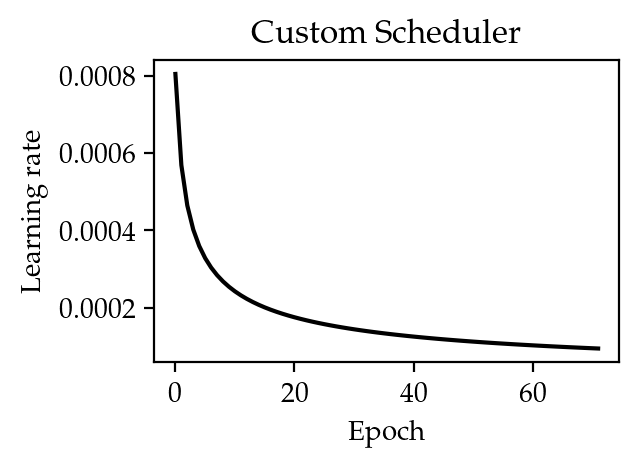

In [11]:
plt.figure(figsize=(3,2), dpi=200)
plt.plot(np.array(train_metrics['epoch_learning_rate']), color='k')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Custom Scheduler')
plt.show()

Text(0.5, 0, 'Number of Epochs')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


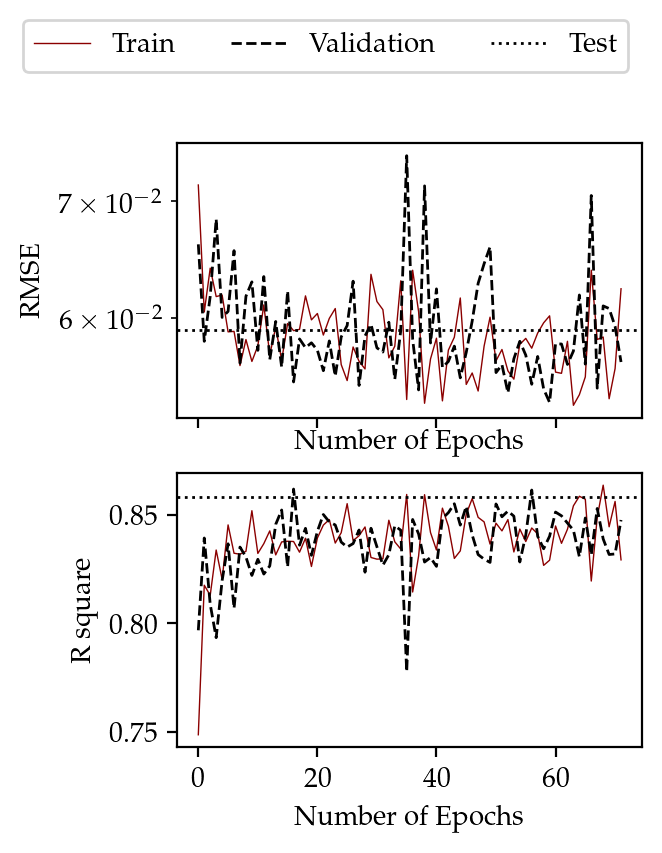

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(3,4), 
                         sharex=True, 
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.3}, 
                        dpi=200)

train_values = np.array(train_metrics['epoch_loss'])
vaild_values = np.array(val_metrics['epoch_loss'])

axes[0].plot(train_values, label='Train', color='darkred', linewidth=0.5)
axes[0].plot(vaild_values, label='Validation', color='k', linestyle='--', 
           linewidth=1)
axes[0].set_ylabel('RMSE')
axes[0].set_yscale('log')
axes[0].axhline(rmse, linestyle=':', linewidth=1, 
             color='k', label='Test')

axes[0].set_xlabel('Number of Epochs')

train_values = np.array(train_metrics['epoch_r2'])
vaild_values = np.array(val_metrics['epoch_r2'])

axes[1].plot(train_values, label='Train', color='darkred', linewidth=0.5)
axes[1].plot(vaild_values, label='Validation', color='k', linestyle='--', linewidth=1)
axes[1].set_ylabel('R square')
# axes[1].set_ylim(-0.002, 0.01)
axes[1].axhline(r2, linestyle=':', linewidth=1, 
             color='k', label='Test')


# axes[0].text(40, 0.4, 
#           'Test R2: {:.3f}'.format(r2), 
#           color='k')
# axes[0].text(10, 0.4, 
#           'Test RMSE: {:.3f}'.format(rmse), 
#           color='k')
axes[0].legend(ncol=3, bbox_to_anchor=(1, 1.5))
axes[1].set_xlabel('Number of Epochs')


## Visualizing predictions

/tmp/ipykernel_475111/1285093623.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


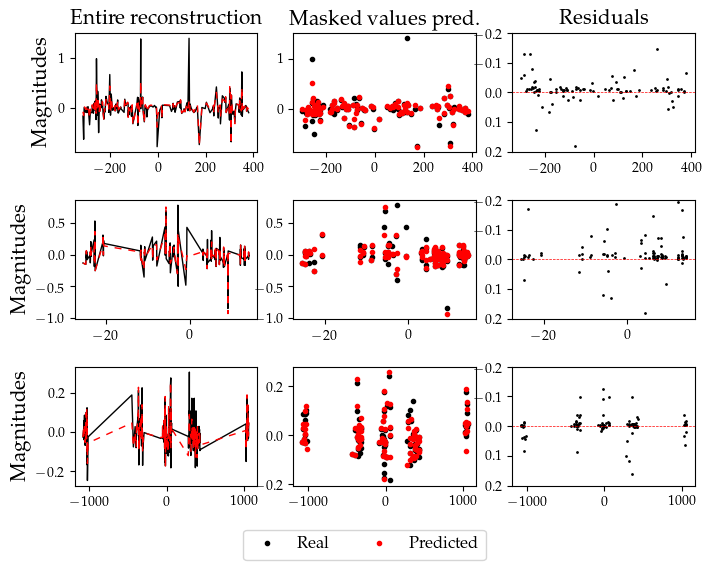

In [31]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=100, figsize=(8,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

for i, (x, (y, mask)) in enumerate(dataset.unbatch().batch(1).take(N)):
    
    y_pred = astromer(x)
    if i == 0:
        axes[i][0].set_title('Entire reconstruction', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][2].set_title('Residuals', fontsize=15)
        
        
    # ENTIRE LIGHT CURVE
    axes[i][0].plot(x['times'][0], y[0], marker='', linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(x['times'][0], y_pred[0], marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    # MASKED VALUES
    true_mask = tf.boolean_mask(y, mask)
    pred_mask = tf.boolean_mask(y_pred, mask)
    time_mask = tf.boolean_mask(x['times'], mask)
    
    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')
    
    # RESIDUALS
    residuals = true_mask - pred_mask
    axes[i][2].plot(time_mask, residuals, '.', markersize=2, color='k')
    axes[i][2].axhline(y=0., color='r', linestyle='--', linewidth=0.5)
    axes[i][2].set_ylim(0.2, -0.2)
    
axes[-1][1].legend(ncol=3, bbox_to_anchor = (1.1, -0.3), fontsize=12)


fig.tight_layout()

In [64]:
# fig.savefig('presentation/figures/pretraining.pdf', format='pdf', bbox_inches='tight') #transparent=True